In [129]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import UninformativePrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [130]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

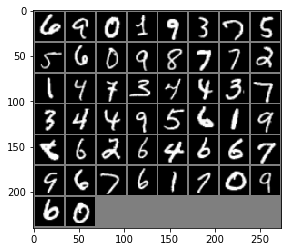

Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py", line 342, in get

In [131]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [132]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [133]:
trainset[0][0].size()

torch.Size([1, 32, 32])

In [139]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

def conv_out_size_same(size, stride):
    return int(math.ceil(size / stride))
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))
        x = x.squeeze()

        return x


In [140]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())


torch.Size([10, 1, 32, 32])
torch.Size([10])


In [141]:
from bgan import BGAN

In [142]:
batch_size = 50
z_dim = 100

In [144]:
prior = UninformativePrior()
gen = GeneratorNetwork()
disc = DiscriminatorNetwork(2)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, disc, prior, alpha=.01, eta=1e-4, disc_lr=1e-5, gen_observed=500)
samples = []

In [145]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.data.numpy()))

torch.Size([100, 512, 4, 4]) 13.0594
torch.Size([512]) 0.329127
torch.Size([512]) 12.8532
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 9.23741
torch.Size([256]) 0.100207
torch.Size([256]) 9.18203
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 6.53133
torch.Size([128]) 0.0983997
torch.Size([128]) 6.57066
torch.Size([128]) 0.0
torch.Size([128, 1, 4, 4]) 0.574509
torch.Size([1]) 0.0078556


## Training

In [146]:
num_samples = 100

In [147]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(500):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
        print(i)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv)
        print('\t', d_loss.data.numpy()[0], g_loss.data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).data.numpy())
samples = np.vstack(samples)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Process Process-5:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py

KeyboardInterrupt: 

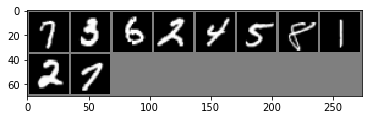

In [148]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [297]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [149]:
samples = bgan.sample(100).data.numpy()

In [150]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [151]:
samples_arr.shape

(100, 1, 32, 32)

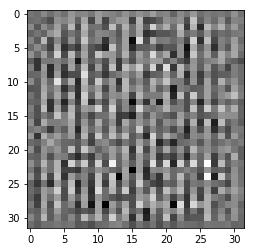

In [152]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [153]:
np.max(batch.numpy())

1.0

In [154]:
samples_arr.shape

(100, 1, 32, 32)

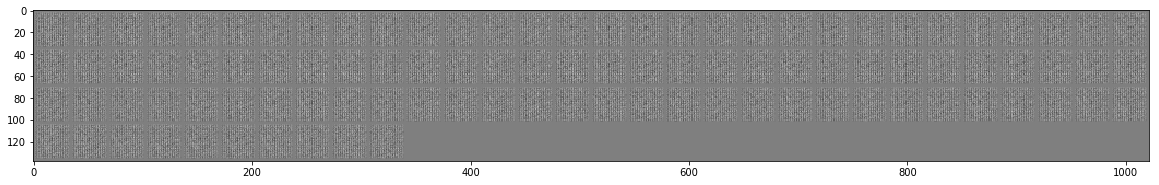

In [155]:
plt.figure(figsize=(20, 50))
show_epochs = [0, 10]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))


In [156]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())[:, 0]

AssertionError: Torch not compiled with CUDA enabled

In [157]:
sample_probs

NameError: name 'sample_probs' is not defined

In [679]:
disc(Variable(batch).cuda())[:, 0]

Variable containing:
 0.7235
 0.7993
 0.7501
 0.8424
 0.4019
 0.8174
 0.7988
 0.8607
 0.8839
 0.7365
 0.8428
 0.8265
 0.6104
 0.7270
 0.7838
 0.8431
 0.8651
 0.8589
 0.7899
 0.8175
 0.7914
 0.8455
 0.7148
 0.7867
 0.5143
 0.7957
 0.8807
 0.7820
 0.7927
 0.7861
 0.7605
 0.7809
 0.7754
 0.8324
 0.8999
 0.8361
 0.7216
 0.8109
 0.8405
 0.8527
 0.8221
 0.8806
 0.7403
 0.7628
 0.8398
 0.7767
 0.6398
 0.7129
 0.8650
 0.7762
[torch.cuda.FloatTensor of size 50 (GPU 0)]